# Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

from pandas import read_csv

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100


ModuleNotFoundError: No module named 'mendeleev'


# Function that sets up HNC QSP 

### Create and run plasma

In [3]:
name='Al'
Z, A = 13, 27
mi = m_p * A
ρ_gpercc =  2.7 
ni_cc = ρ_gpercc/(mi*AU_to_g)
ri_cm = rs_from_n(ni_cc)
ri_AU = ri_cm*cm_to_AU


### Make βu_ii, βu_fi from using bound density from AA
If we assume the bound state does not deform at all, then we can calculate potentials based on it easily via integration

### Solving

In [4]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

def custom_flat(hnc_matrix):
    hnc_flat = np.concatenate([hnc_matrix[0,0],hnc_matrix[0,1],hnc_matrix[1,1]])
    return hnc_flat

def custom_unflat(hnc_flat):
    hnc00, hnc01, hnAl11 = np.split(hnc_flat,3)
    hnc_matrix = np.zeros((2,2,len(hnc00)))
    hnc_matrix[0,0] = hnc00
    hnc_matrix[1,0] = hnc01
    hnc_matrix[0,1] = hnc01
    hnc_matrix[1,1] = hnAl11
    return hnc_matrix

def solve_least_squares(plasma, sparse_k_array, c_s_k_guess=None, ftol=1e-8):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    # Create functions for converting between sparse, not sparse and flattened versions of c_s_k
    get_sparse_csk = lambda c_s_k_flat: np.concatenate([interp1d(plasma.hnc.k_array, c_s_k)(sparse_k_array) for c_s_k in np.split(c_s_k_flat,3) ])
    get_csk = lambda sparse_hnc_csk: interp1d(sparse_k_array, sparse_hnc_csk, kind='cubic')(plasma.hnc.k_array)
    get_csk_matrix_from_sparse_csk_flat =  lambda sparse_c_s_k_flat: custom_unflat(np.concatenate([get_csk(sparse_csk) for sparse_csk in np.split(sparse_c_s_k_flat,3)]))
    
    def min_function(sparse_c_s_k_flat):
        c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sparse_c_s_k_flat)
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        plasma.hnc.c_s_k_matrix = new_c_s_k_matrix.copy()
        new_c_s_k_flat = custom_flat(new_c_s_k_matrix)
        return sparse_c_s_k_flat - get_sparse_csk(new_c_s_k_flat)
    
    c_s_k_flat_guess = custom_flat(c_s_k_guess)
    c_s_k_sparse_guess = get_sparse_csk(c_s_k_flat_guess)
    sol = least_squares(min_function, c_s_k_sparse_guess, verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    plasma.hnc.c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sol.x)
    plasma.hnc.set_all_matrices_from_csk(plasma.hnc.c_s_k_matrix)
    print(sol)

def best_shift(plasma, c_s_k_guess = None, ftol=1e-8, set=True):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    def min_function(multiplier_list):
        xii, xei, xee = multiplier_list
        multiplier_matrix = np.array([[xii,xei],[xei,xee]])
        c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * c_s_k_guess
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        
        return c_s_k_matrix.flatten() - new_c_s_k_matrix.flatten()
    
    sol = least_squares(min_function, np.ones((3)) , verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    xii, xei, xee = sol.x
    multiplier_matrix = np.array([[xii,xei],[xei,xee]])
    
    plasma.hnc.c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * c_s_k_guess
    print(sol)
    return sol

In [5]:
def make_Ashcroft_βvei(atom, α=1, Rc = 0.4):
    # Assumes Rc in terms of Wigner-Seitz radius already as are hnc units
    k = atom.hnc.k_array
    βvei= atom.hnc.FT_k_2_r(  4*π*atom.qsp.Γei* (np.cos(k*Rc)*(1-α) + α*np.sin(k*Rc)/(k*Rc)) * (1/k**2 - 1/(k**2 + 1/atom.qsp.Λei**2)) )
    atom.hnc.βu_r_matrix[0,1] = βvei
    atom.hnc.βu_r_matrix[1,0] = βvei
    atom.hnc.set_βu_matrix(atom.hnc.βu_r_matrix)

In [6]:
def plasma_f(T_eV, Rc, Zbar, closure='svt'):
    plasma = PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, find_βuee=False,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options = {'Te_c_type':'DMC'},
             hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':closure},
             hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':2000},
             root_options={'options':{'maxfev':100,'xtol':1e-14}})
    
    # Make the smoothed Ashcroft potential 
    make_Ashcroft_βvei(plasma, α=0, Rc = Rc)
    
    return plasma

In [7]:
def ocp_f(T_eV, Zbar):
    ocp = PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, find_βuee=False,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':2000},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
    ocp.run_ocp_hnc()
    return ocp

def yp_f(T_eV, Zbar):
    yukawa_plasma =  PLASMA(Z, A, ni_cc, T_eV, T_eV, Zbar=Zbar, find_βuee=False,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':2000},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
    yukawa_plasma.run_yukawa_hnc();
    return yukawa_plasma

In [8]:
def save_plasma(plasma, Rc):
    T_eV = plasma.Ti_eV
    Zbar = plasma.qsp.Zbar
    ocp = ocp_f( T_eV, Zbar)
    yp  = yp_f(T_eV, Zbar )
    
    # Make header
    info_header = (f"# Zach Johnson Dec/11/2023 CHNC for TCCW Paper" + '\n' + 
                   f"# Ti={T_eV:0.3e}[eV], Tie={plasma.qsp.Tie_c*AU_to_eV:0.3e}[eV] , Te_c={plasma.qsp.Te_c*AU_to_eV:0.3e}[eV], n_i={plasma.ni_cc:0.3e}[1/cc], n_e={Zbar*plasma.ni_cc:0.3e}[1/cc]" + '\n' + 
                   f"# ri={ri_AU:0.3f}, Zbar={Zbar:0.3f}, Rc={Rc:0.3f}[AU], Γii={plasma.qsp.Γii:0.3e}, Γei={plasma.qsp.Γei:0.3e} , Γee={plasma.qsp.Γee:0.3e}, κ={plasma.qsp.get_κ():0.3e}" 
                  )
    column_header = f"{'r/ri':10}  {'g_ii':10}  {'g_ei':10}  {'g_ee':10}  {'OCP:g_ii':10}  {'Yuk:g_ii':10}  {'βu_ii_eff':10}  {'βu_OCP':10}  {'βu_Yuk':10}"
    header = info_header + '\n' + column_header
    
    # Make save array
    save_array = np.array([  plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1, plasma.hnc.h_r_matrix[0,1]+1, plasma.hnc.h_r_matrix[1,1]+1,
                           ocp.ocp_hnc.h_r_matrix[0,0]+1, yp.yuk_hnc.h_r_matrix[0,0] + 1, plasma.hnc.βueff_r_matrix_with_B[0,0],
                           ocp.ocp_hnc.βu_r_matrix[0,0], yp.yuk_hnc.βu_r_matrix[0,0]]).T
    
    np.savetxt(f"/home/zach/plasma/hnc/TCCW/Final_TCCW/results/CHNC_Al_rs{ri_AU:0.3f}_TeV{plasma.Ti_eV:0.3f}.dat", save_array, 
               header=header, fmt='%10.5e', comments='')

### Now Load Data from George
Rc is interpreted as the average bound radius, in AU in the file. Empty-core Ashcroft assumed.

In [9]:
GP_data   = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/GP_data/Al_combined.dat", header=0, delim_whitespace=True)
T_eV_list = GP_data['Te(eV)']
Rc_list   = GP_data['Rc'] # AU
Zbar_list = GP_data['Z_bar'] #Average atom Zbar GP_data
GP_data

,Te(eV),rho/rho0,Ne_b,Ne_quasi,Ne_sc,Z_bar,Rc,mu,nu_mom,nu_tot,sigma,k_th,L,G
0,0.1,1.0,10.000,0.0,3.000,3.000,0.514,0.288900,0.01607,0.09550,1.0740,0.01299,3.293,1.713000e-08
1,0.2,1.0,10.000,0.0,3.000,3.000,0.517,0.329200,0.01455,0.07732,1.0620,0.02592,3.321,2.510000e-08
2,0.5,1.0,10.000,0.0,3.000,3.000,0.518,0.330800,0.01410,0.07276,1.1130,0.06950,3.399,2.533000e-08
3,1.0,1.0,10.000,0.0,3.000,3.000,0.521,0.331400,0.01352,0.06448,1.2280,0.14220,3.153,2.608000e-08
4,2.0,1.0,10.000,0.0,3.000,3.000,0.525,0.327300,0.01493,0.05904,1.2480,0.22160,2.417,3.186000e-08
5,5.0,1.0,10.000,0.0,3.005,3.005,0.533,0.258500,0.02399,0.05507,1.0810,0.29680,1.494,6.148000e-08
6,10.0,1.0,9.932,0.0,3.068,3.068,0.538,0.007439,0.04736,0.07723,0.7355,0.35850,1.327,1.238000e-07
7,20.0,1.0,9.108,0.0,3.892,3.892,0.513,-0.692100,0.10870,0.20160,0.2711,0.51860,2.602,2.779000e-07
8,50.0,1.0,6.893,0.0,6.107,6.107,0.486,-3.522000,0.27120,0.55740,0.2203,1.42500,3.520,6.410000e-07
9,100.0,1.0,4.599,0.0,8.401,8.401,0.397,-9.565000,0.27220,0.59680,0.4190,5.61800,3.649,8.146000e-07


In [10]:
plasma_list = []

for T_eV, Rc, Zbar in zip(T_eV_list[3:4], Rc_list[3:4], Zbar_list[3:4]):
    plasma = plasma_f(T_eV, Rc/ri_AU, Zbar )    
    plasma_list.append(plasma)

Te_in_eV: 1.000
Ti_in_eV: 1.000


In [94]:
guess_c_s_k_matrix = None
for Rc, plasma in zip(Rc_list[3:4], plasma_list): 
    # if T_eV == 1.0:
    print(f"T_eV = {plasma.Ti_eV}")
    plasma.run_hnc(c_s_k_guess = guess_c_s_k_matrix)
    if plasma.hnc.tot_err_list[-1] > 1e-7:
        best_shift(plasma)
        solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=200))
        solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=400))
        save_plasma(plasma, Rc)
    else:
        save_plasma(plasma, Rc)
    # guess_c_s_k_matrix = plasma.hnc.c_s_k_matrix.copy()

T_eV = 1.0
0: Initial condition Total Error: 1.272e+01
QUIT: Last 10 iterations error has been increasing
Exiting status 2, reverting to best index so far: 501
Final iter:510, Total Error: 9.890e-04
Adjusting
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1125e-03                                    9.96e+00    
       1              2         3.8753e-03      2.37e-04       8.78e-02       2.31e+00    
       2              3         3.6599e-03      2.15e-04       2.20e-02       1.48e+00    
       3              5         3.6279e-03      3.19e-05       5.49e-03       3.12e-01    
       4              6         3.6230e-03      4.96e-06       1.37e-03       3.70e-02    
       5              7         3.6178e-03      5.12e-06       3.43e-04       2.48e-02    
       6             16         3.6178e-03      0.00e+00       0.00e+00       2.48e-02    
`xtol` termination condition is satisfied.
Function evaluations


KeyboardInterrupt



In [95]:
solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=1000))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.6528e-03                                    1.79e+00    
       1              2         9.8194e-05      6.55e-03       5.91e-01       1.73e-01    
       2              3         5.2356e-09      9.82e-05       9.95e-02       5.80e-04    
       3              4         1.4407e-13      5.24e-09       9.08e-04       2.21e-06    
       4              5         7.1629e-17      1.44e-13       4.78e-06       6.97e-08    
       5              6         3.8651e-17      3.30e-17       1.31e-07       1.02e-07    
`xtol` termination condition is satisfied.
Function evaluations 6, initial cost 6.6528e-03, final cost 3.8651e-17, first-order optimality 1.02e-07.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 3.702e-09  3.643e-09 ... -2.193e-18 -3.012e-19]
           x: [ 1.130e+02  1.117e+02 ... -9.388e-10 -3.126e

### Plot and Comparison to QMD

In [18]:
for plasma, Rc in zip(plasma_list[3:4], Rc_list[3:4]):    
    save_plasma(plasma, Rc)

Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 2.552e+01
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 512
Final iter:515, Total Error: 9.836e-09
Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 2.507e+02
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 499
Final iter:502, Total Error: 2.870e-09


## Aluminum Final Plots

In [26]:
Al1_GP = read_csv("~/plasma/hnc/TCCW/Final_TCCW/GP_data/GP_Al1_profile.dat", delim_whitespace=True, header=0)
Al1_GP

,x,r,Vcoul,Vexc,V,rV,dNedr_b,dNedr_s,dNedr_f,dNedr,ne_b,ne_s,ne_f,ne
0,0.000026,0.000077,1.690000e+05,9.337000,1.690000e+05,1.300000e+01,0.000102,0.000000e+00,0.000001,0.000102,1372.000000,0.00000,19.58000,1372.00000
1,0.000026,0.000078,1.672000e+05,9.348000,1.672000e+05,1.300000e+01,0.000104,3.363000e-07,0.000001,0.000105,1372.000000,4.42800,19.47000,1377.00000
2,0.000026,0.000079,1.654000e+05,9.348000,1.654000e+05,1.300000e+01,0.000106,3.434000e-07,0.000002,0.000107,1372.000000,4.42800,19.37000,1377.00000
3,0.000026,0.000079,1.637000e+05,9.348000,1.637000e+05,1.300000e+01,0.000109,3.508000e-07,0.000002,0.000109,1372.000000,4.42800,19.27000,1377.00000
4,0.000027,0.000080,1.620000e+05,9.348000,1.620000e+05,1.300000e+01,0.000111,3.583000e-07,0.000002,0.000111,1372.000000,4.42800,19.17000,1377.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.958600,2.873200,2.264000e-03,0.002977,5.266000e-03,1.513000e-02,0.001956,2.409000e+00,1.956000,2.411000,0.000019,0.02322,0.01885,0.02324
997,0.968790,2.903700,1.274000e-03,0.002215,3.507000e-03,1.018000e-02,0.001738,2.438000e+00,1.984000,2.439000,0.000016,0.02301,0.01872,0.02302
998,0.979080,2.934600,5.665000e-04,0.001464,2.042000e-03,5.992000e-03,0.001545,2.467000e+00,2.014000,2.469000,0.000014,0.02280,0.01861,0.02281
999,0.989490,2.965700,1.417000e-04,0.000726,8.725000e-04,2.588000e-03,0.001372,2.497000e+00,2.046000,2.499000,0.000012,0.02259,0.01851,0.02261


In [27]:
Al1_CHNC = read_csv("~/plasma/hnc/TCCW/Final_TCCW/results/CHNC_Al_rs2.998_TeV1.000.dat", delim_whitespace=True, header=3)
Al1_ri = 2.998
Al1_Zbar = 3
Al1_ne0 = Al1_Zbar/(4/3*np.pi*Al1_ri**3)
Al1_CHNC

,r/ri,g_ii,g_ei,g_ee,OCP:g_ii,Yuk:g_ii,βu_ii_eff,βu_OCP,βu_Yuk
0,0.01,0.340576,2.02994,0.150415,3.613680e-08,0.0,8.043590e+03,8169.35000,7.895300e+03
1,0.02,0.337700,2.04375,0.155646,3.610060e-08,0.0,3.959450e+03,4085.16000,3.815670e+03
2,0.03,0.333259,2.06719,0.161490,3.601590e-08,0.0,2.598120e+03,2723.77000,2.458740e+03
3,0.04,0.327504,2.10032,0.167975,3.594570e-08,0.0,1.917520e+03,2043.07000,1.782400e+03
4,0.05,0.320664,2.14394,0.175125,3.582220e-08,0.0,1.509230e+03,1634.65000,1.378250e+03
...,...,...,...,...,...,...,...,...,...
995,9.96,1.000000,1.00000,1.000000,9.996750e-01,1.0,-9.202660e-09,8.20118,1.605450e-14
996,9.97,1.000000,1.00000,1.000000,9.996720e-01,1.0,-9.191600e-09,8.19295,1.550220e-14
997,9.98,1.000000,1.00000,1.000000,9.996710e-01,1.0,-9.180910e-09,8.18475,1.496900e-14
998,9.99,1.000000,1.00000,1.000000,9.996700e-01,1.0,-9.170690e-09,8.17655,1.445410e-14


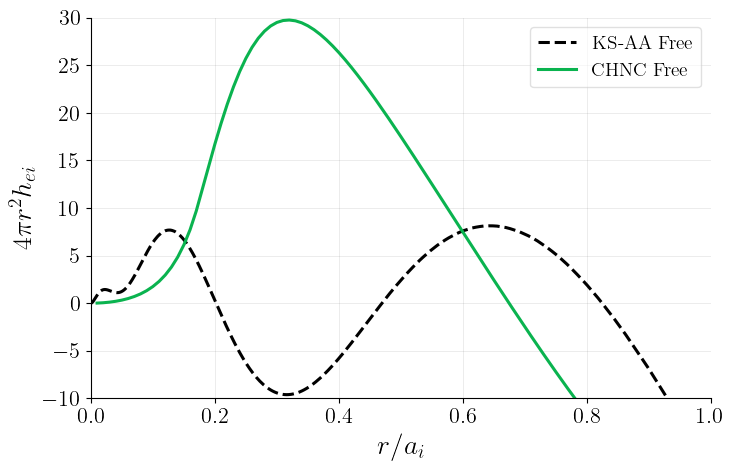

In [28]:
def g_ei_plot(ax):
    ax.plot(Al1_GP['x'], (Al1_GP['ne_s']/Al1_ne0-1)*4*π*(Al1_GP['r'])**2,'k--', label="KS-AA Free"  )
    ax.plot(Al1_CHNC['r/ri'],(Al1_CHNC['g_ei']-1)*4*π*(Al1_CHNC['r/ri']*Al1_ri)**2, label="CHNC Free"  )

    ax.set_xlim(0,1)
    ax.set_ylim(-10,30)
    ax.set_ylabel(r"$4\pi r^2 h_{ei}$")
    ax.set_xlabel(r"$r/a_i$")
    ax.legend()

fig, ax  = plt.subplots()
g_ei_plot(ax)

In [54]:
np.concatenate([list(np.linspace(0.1*10**n,1*10**n,num=10)) for n in range(5)])

array([1.e-01, 2.e-01, 3.e-01, 4.e-01, 5.e-01, 6.e-01, 7.e-01, 8.e-01,
       9.e-01, 1.e+00, 1.e+00, 2.e+00, 3.e+00, 4.e+00, 5.e+00, 6.e+00,
       7.e+00, 8.e+00, 9.e+00, 1.e+01, 1.e+01, 2.e+01, 3.e+01, 4.e+01,
       5.e+01, 6.e+01, 7.e+01, 8.e+01, 9.e+01, 1.e+02, 1.e+02, 2.e+02,
       3.e+02, 4.e+02, 5.e+02, 6.e+02, 7.e+02, 8.e+02, 9.e+02, 1.e+03,
       1.e+03, 2.e+03, 3.e+03, 4.e+03, 5.e+03, 6.e+03, 7.e+03, 8.e+03,
       9.e+03, 1.e+04])

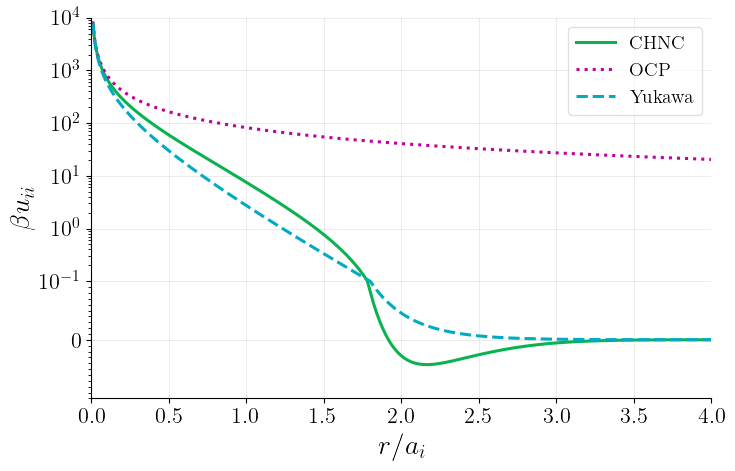

In [57]:
from matplotlib.ticker import AutoMinorLocator

def βu_ii_eff_plot(ax):
    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['βu_ii_eff'], label="CHNC"  )
    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['βu_OCP'],':', label="OCP"  )
    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['βu_Yuk'],'--', label="Yukawa"  )

    ax.set_xlim(0,4)
    ax.set_ylim(-0.1,1e4)
    ax.set_yscale('symlog', linthresh=0.1)
    ax.set_ylabel(r"$\beta u_{ii}$")
    ax.set_xlabel(r"$r/a_i$")
    
    custom_minor_ticks = list(np.linspace(-0.1,0.1,num=21)) + list(np.concatenate([list(np.linspace(0.1*10**n,1*10**n,num=10)) for n in range(5)]))
    ax.set_yticks(custom_minor_ticks, minor=True)

    ax.legend()
    
fig, ax  = plt.subplots()
βu_ii_eff_plot(ax)

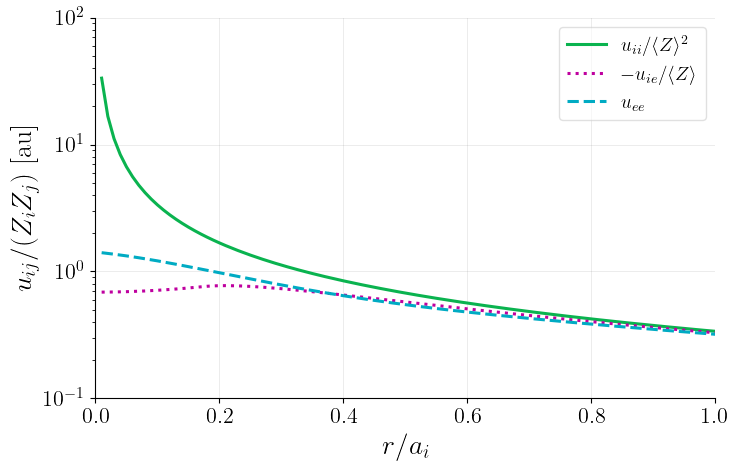

In [58]:
plasma = plasma_list[0]
def βu_ii_plot(ax):
    ax.plot(Al1_CHNC['r/ri'], plasma.qsp.Ti*plasma.hnc.βu_r_matrix[0,0]/plasma.Zbar**2, label=r"$u_{ii}/\langle Z\rangle^2$"  )
    ax.plot(Al1_CHNC['r/ri'],-plasma.qsp.Tie_c*plasma.hnc.βu_r_matrix[0,1]/plasma.Zbar,':', label=r"$-u_{ie}/\langle Z\rangle$"  )
    ax.plot(Al1_CHNC['r/ri'], plasma.qsp.Te_c*plasma.hnc.βu_r_matrix[1,1],'--', label=r"$u_{ee}$"  )

    ax.set_xlim(0,1)
    ax.set_ylim(1e-1,1e2)
    ax.set_yscale('log')
    ax.set_ylabel(r"$u_{ij}/(Z_i Z_j) $ [au]")
    ax.set_xlabel(r"$r/a_i$")
    ax.legend()
    
fig, ax  = plt.subplots()
βu_ii_plot(ax)

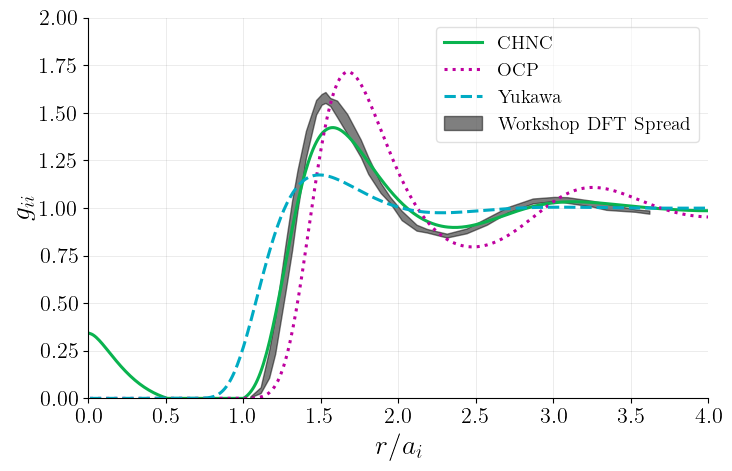

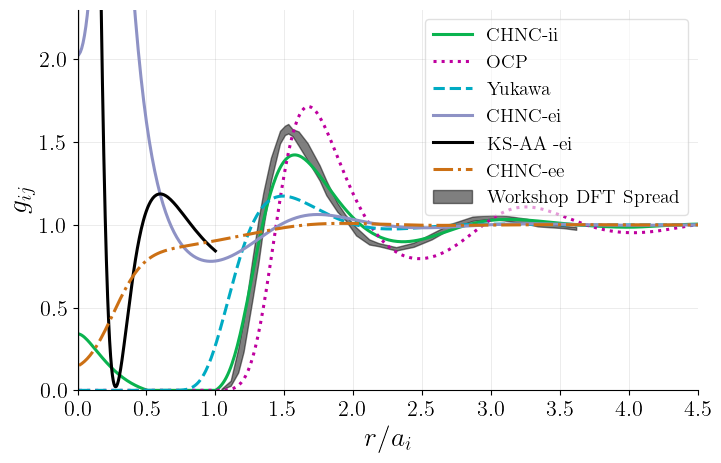

In [69]:
from scipy.interpolate import CubicSpline, PchipInterpolator

def g_ii_plot(ax):
    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['g_ii'], label="CHNC"  )
    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['OCP:g_ii'],':', label="OCP"  )
    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['Yuk:g_ii'],'--', label="Yukawa"  )

    # Data from community TCCW
    upper_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Upper.txt", delim_whitespace=True, header=1)
    lower_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Lower.txt", delim_whitespace=True, header=1)
    
    ax.fill_between(lower_data['r/ri'],lower_data['gii'], PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='Workshop DFT Spread')
    ax.set_xlim(0,4)
    ax.set_ylim(0,2)
    # ax.set_yscale('symlog', linthresh=0.1)
    ax.set_ylabel(r"$g_{ii}$")
    ax.set_xlabel(r"$r/a_i$")
    ax.legend()

fig, ax  = plt.subplots( figsize=(8, 4.9443))
g_ii_plot(ax)

def g_ij_plot(ax):
    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['g_ii'], label="CHNC-ii"  )
    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['OCP:g_ii'],':', label="OCP"  )
    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['Yuk:g_ii'],'--', label="Yukawa"  )

    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['g_ei'], label="CHNC-ei"  )
    ax.plot(Al1_GP['x'], (Al1_GP['ne_s']/Al1_ne0), 'k-', label="KS-AA -ei "  )

    ax.plot(Al1_CHNC['r/ri'],Al1_CHNC['g_ee'],'-.', label="CHNC-ee"  )
     
    # Data from community TCCW
    upper_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Upper.txt", delim_whitespace=True, header=1)
    lower_data = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/Fig5c_Lower.txt", delim_whitespace=True, header=1)
    
    ax.fill_between(lower_data['r/ri'],lower_data['gii'], PchipInterpolator(upper_data['r/ri'], upper_data['gii'])(lower_data['r/ri']), alpha=0.5, color='k', label='Workshop DFT Spread')

    ax.set_xlim(0,4.5)
    ax.set_ylim(0,2.3)
    # ax.set_yscale('symlog', linthresh=0.1)
    ax.set_ylabel(r"$g_{ij}$")
    ax.set_xlabel(r"$r/a_i$")
    ax.legend(loc='upper right')

fig, ax  = plt.subplots( figsize=(8, 4.9443))
g_ij_plot(ax)

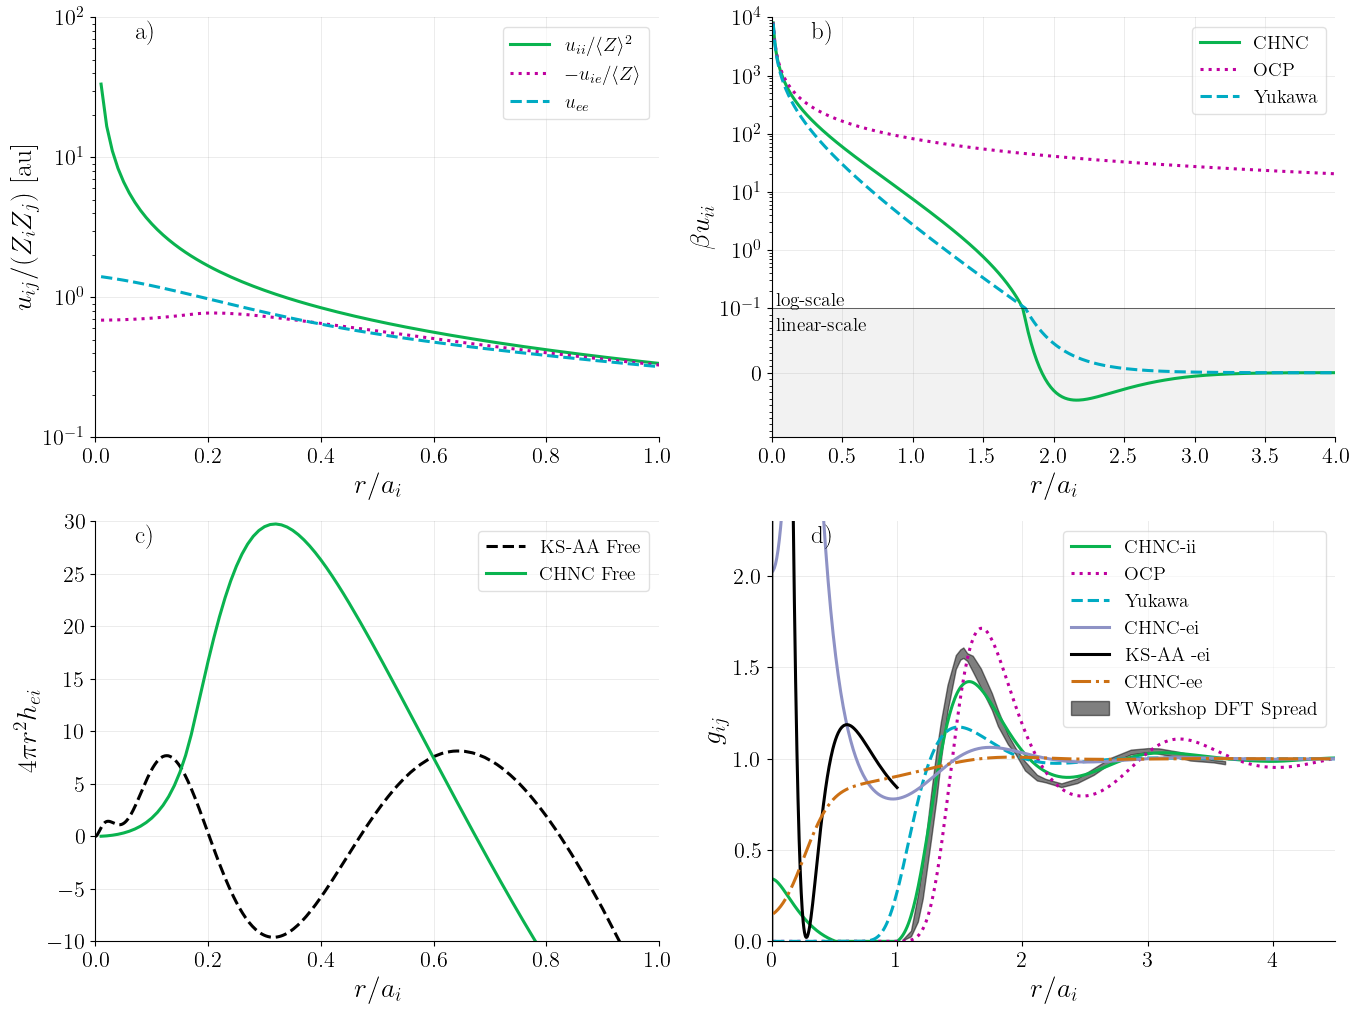

In [70]:
fig, axs = plt.subplots(2,2, figsize=(16, 12))

βu_ii_plot(axs[0,0])
βu_ii_eff_plot(axs[0,1])
g_ei_plot(axs[1,0])
g_ij_plot(axs[1,1])
axs[0,1].axhline(y=0.1,color='k',linewidth=0.4)
axs[0,1].fill_between(np.linspace(0,10),-1,0.1,color='k',alpha=0.05)
axs[0,1].text(0.03, 0.11, "log-scale",fontsize=14)
axs[0,1].text(0.03, 0.065, "linear-scale",fontsize=14)
# Subfigure Labels
axs[0,0].text(0.07, 0.95, "a)", transform=axs[0,0].transAxes, fontsize=18)
axs[0,1].text(0.07, 0.95, "b)", transform=axs[0,1].transAxes, fontsize=18)
axs[1,0].text(0.07, 0.95, "c)", transform=axs[1,0].transAxes, fontsize=18)
axs[1,1].text(0.07, 0.95, "d)", transform=axs[1,1].transAxes, fontsize=18)

plt.savefig("/home/zach/plasma/hnc/TCCW/Final_TCCW/Al1_gβu_plot.png", dpi=400)


## Make Viscosity points

Text(0, 0.5, '$R_c$')

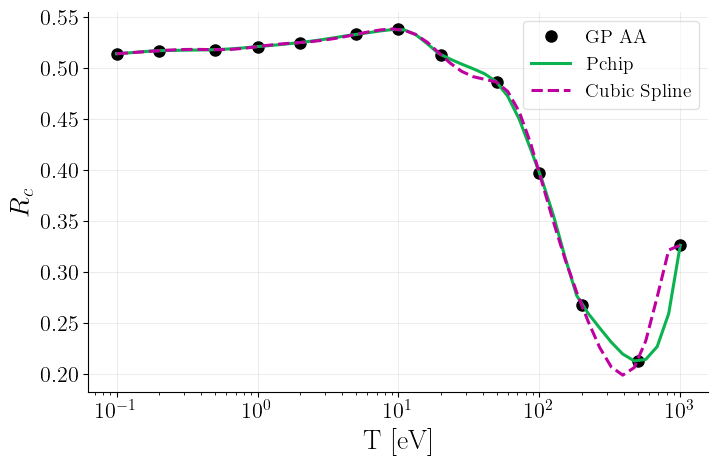

In [33]:
from scipy.interpolate import CubicSpline, PchipInterpolator

Al_GP_df = read_csv("/home/zach/plasma/hnc/TCCW/Final_TCCW/GP_data/Al_combined.dat", delim_whitespace=True)

# ____ Al ____
GP_Al_T_few = Al_GP_df["Te(eV)"].to_numpy()
GP_Al_Z_bar = Al_GP_df["Z_bar"].to_numpy()
GP_Al_Rc    = Al_GP_df["Rc"].to_numpy()

# Pchip spline
Zbar_interp = PchipInterpolator(GP_Al_T_few, GP_Al_Z_bar)
Zbar_interp

Rc_interp_Pchip   = PchipInterpolator(GP_Al_T_few, GP_Al_Rc)
Rc_interp_cubic   = CubicSpline(GP_Al_T_few, GP_Al_Rc)

fig, ax = plt.subplots()
ax.plot(GP_Al_T_few, GP_Al_Rc, 'ko', label='GP AA')
T_geomspace = np.geomspace(np.min(GP_Al_T_few), np.max(GP_Al_T_few))

ax.plot(T_geomspace, Rc_interp_Pchip(T_geomspace), label='Pchip')
ax.plot(T_geomspace, Rc_interp_cubic(T_geomspace),'--', label='Cubic Spline')

# ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()
ax.set_xlabel('T [eV]')
ax.set_ylabel(r'$R_c$')

In [34]:
Smith_lowT_TeV = 0.22405429
Smith_lowT_η = 0.32007164

Rc_interp = Rc_interp_Pchip
plasma_min = plasma_f(Smith_lowT_TeV, Rc_interp(Smith_lowT_TeV), Zbar_interp(Smith_lowT_TeV), closure='svt')

Te_in_eV: 0.224
Ti_in_eV: 0.224


In [35]:
plasma_min.run_hnc()

0: Initial condition Total Error: 3.467e+01
Starting Ng loop, using best index so far:  1999
QUIT: Large Error at many iterations, and error not decreasing.
Exiting status 3, reverting to best index so far: 2008
Final iter:2039, Total Error: 3.969e-02


In [36]:
plasma_min.run_hnc(c_s_k_guess = plasma_min.hnc.c_s_k_matrix)

0: Initial condition Total Error: 3.969e-02
QUIT: Last 10 iterations error has been increasing
Exiting status 2, reverting to best index so far: 9
Final iter:18, Total Error: 2.863e-02


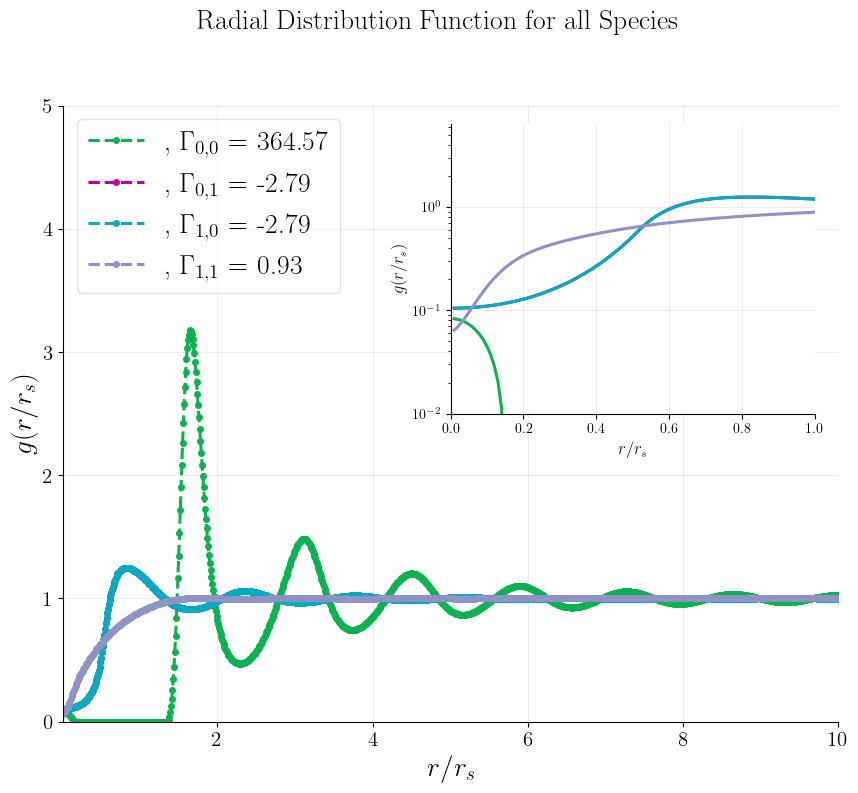

In [37]:
plasma_min.hnc.plot_g_all_species()

## Born Green Viscocity
See [Morioka 2004](https://www.sciencedirect.com/science/article/pii/S0022309304003692)

\begin{align}
η = f_{BG} \frac{2 \pi}{15} \left(\frac{M}{RT} \right)^{1/2} \frac{n^2}{N_a} \int^\infty_0 g(r) \frac{d\phi}{dr}r^4 dr
\end{align}
Resulting units is Pa s


CGS: η = 1.261e+01 [m Pa s]


0.32007164

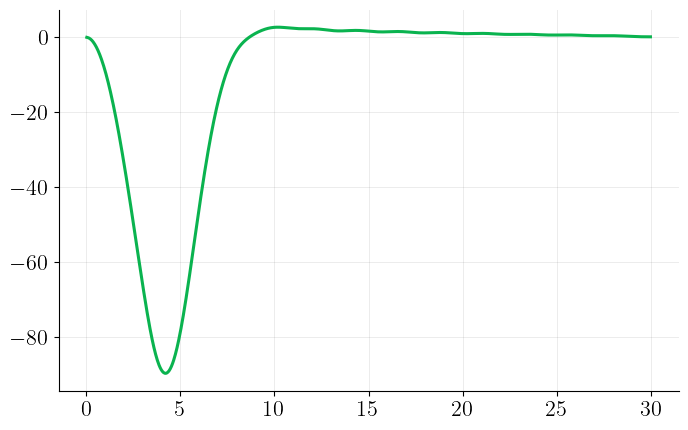

In [189]:
from scipy.integrate import simpson

def get_ηBG(plasma):
    plasma.hnc.invert_HNC_OZ([1])
    fBG = -1
    n_AU = n_from_rs(plasma.qsp.ri)
    r_array = plasma.hnc.r_array*plasma.qsp.ri
    gii = plasma.hnc.h_r_matrix[0,0]+1
    dφdr = plasma.qsp.Ti*np.gradient(plasma.hnc.βueff_r_matrix[0,0], r_array)

    integrand = r_array**4 * gii * dφdr
    ##
    fig, ax = plt.subplots()
    ax.plot(r_array, dφdr*r_array**4)
    ###
    integral = simpson(integrand, x=r_array)
    η = fBG* 2*π/15 * (plasma.qsp.βi*plasma.qsp.m_i)**0.5*n_AU**2*integral
    return η

η_SI = get_ηBG(plasma_min)*AU_to_Pa*AU_to_s # Pa s = kg m^-1 s^-1 
# print(f"SI: η = {η_SI:0.3e} [kg m^-1 s^-1] (or [Pa s])")
# η_cgs = η_SI * 1000/100 # g cm^-1 s^-1
# print(f"CGS: η = {η_cgs:0.3e} [g cm^-1 s^-1]")
ηCHNC_minT_mPas = η_SI*1000
print(f"CGS: η = {ηCHNC_minT_mPas:0.3e} [m Pa s]")

Smith_lowT_η

In [198]:
η_plasma_list = []
for T_eV, Rc, Zbar in zip(GP_Al_T_few[2:], GP_Al_Rc[2:], GP_Al_Z_bar[2:]):
    print(T_eV, Rc, Zbar)
    tmp_plasma = plasma_f(T_eV, Rc, Zbar, closure='svt')
    tmp_plasma.run_hnc()
    η_plasma_list.append(tmp_plasma)

0.5 0.518 3.0
Te_in_eV: 0.500
Ti_in_eV: 0.500
0: Initial condition Total Error: 2.042e+01
Starting Ng loop, using best index so far:  1999
Exiting status 0, reverting to best index so far: 2017
Final iter:2020, Total Error: 7.475e-09
Adjusting
1.0 0.521 3.0
Te_in_eV: 1.000
Ti_in_eV: 1.000
0: Initial condition Total Error: 1.272e+01
Starting Ng loop, using best index so far:  1999
Exiting status 0, reverting to best index so far: 2001
Final iter:2004, Total Error: 7.631e-09
Adjusting
2.0 0.525 3.0
Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 7.775e+00
Exiting status 0, reverting to best index so far: 1893
Final iter:1894, Total Error: 9.929e-09
Adjusting
5.0 0.533 3.005
Te_in_eV: 5.000
Ti_in_eV: 5.000
0: Initial condition Total Error: 3.923e+00
Exiting status 0, reverting to best index so far: 905
Final iter:906, Total Error: 9.974e-09
Adjusting
10.0 0.538 3.068
Te_in_eV: 10.000
Ti_in_eV: 10.000
0: Initial condition Total Error: 2.335e+00
Exiting status 0, reverting

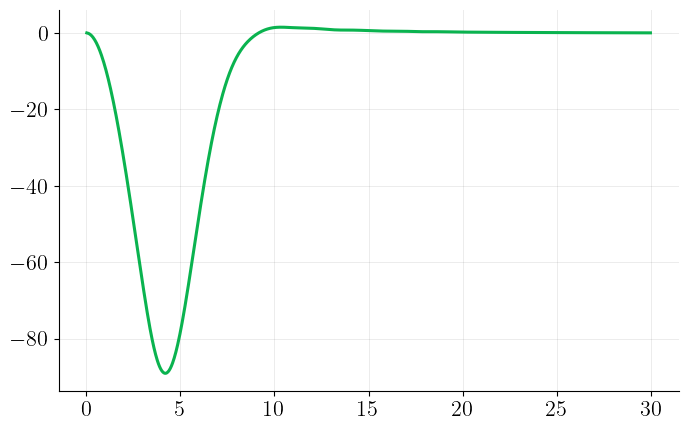

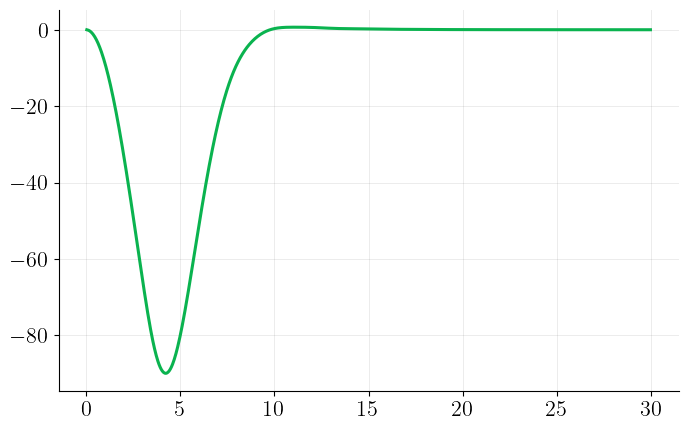

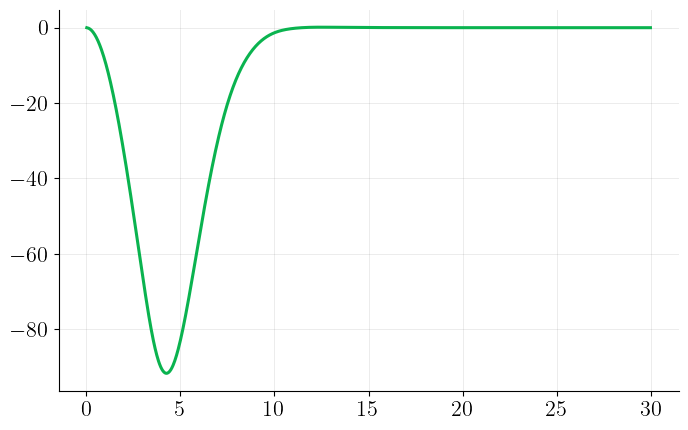

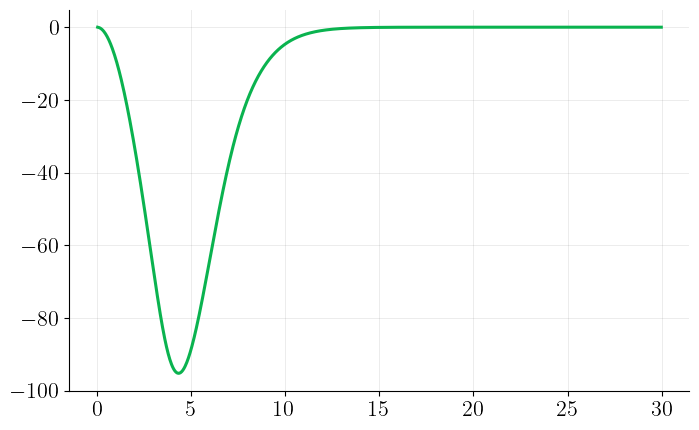

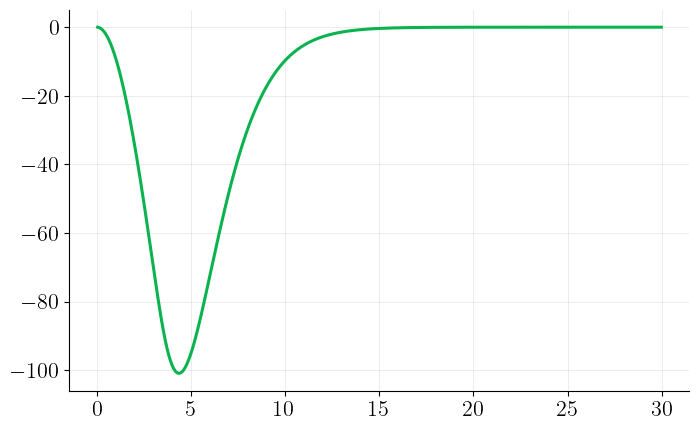

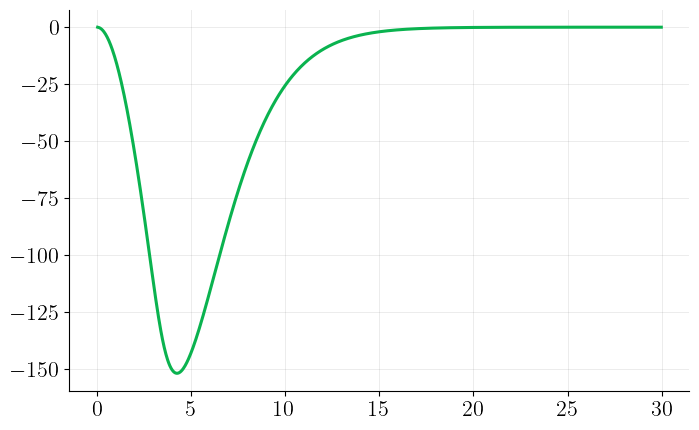

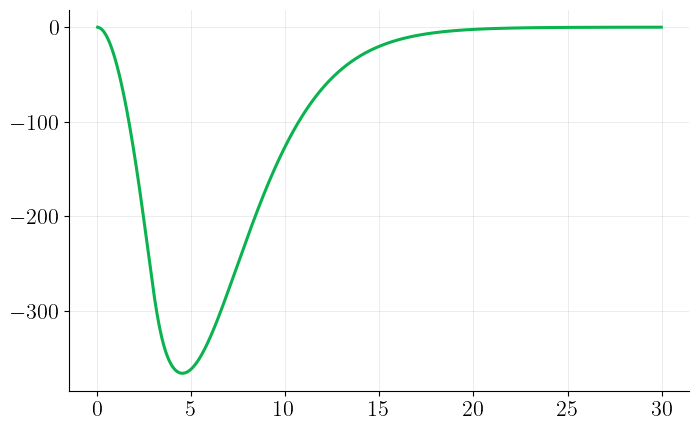

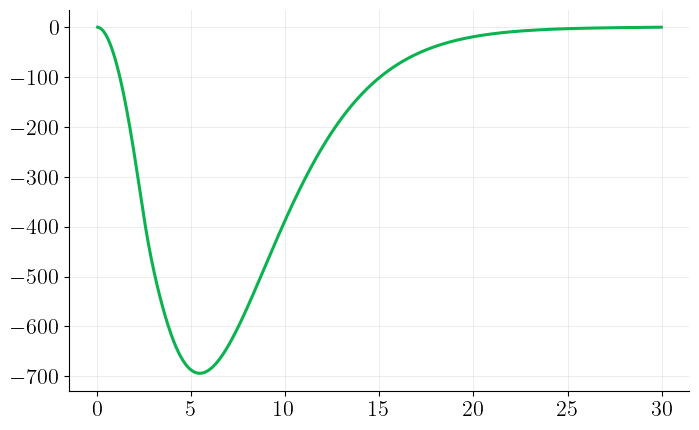

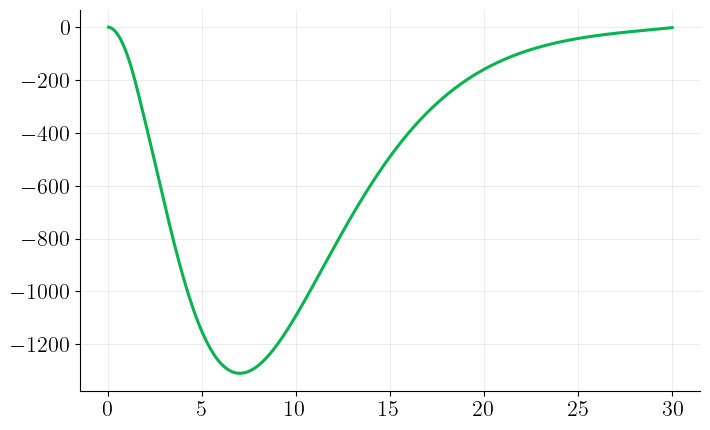

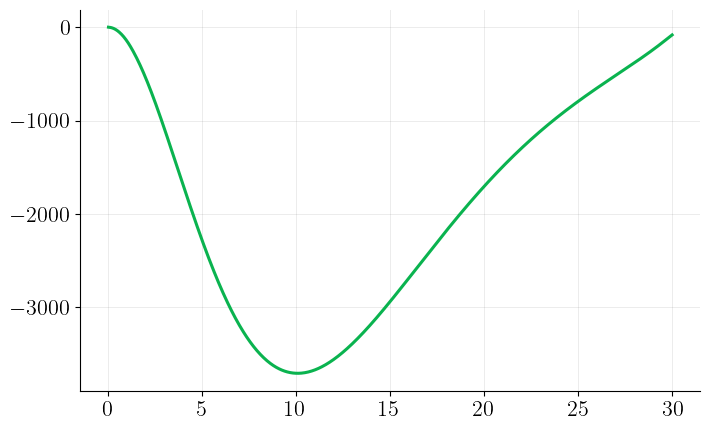

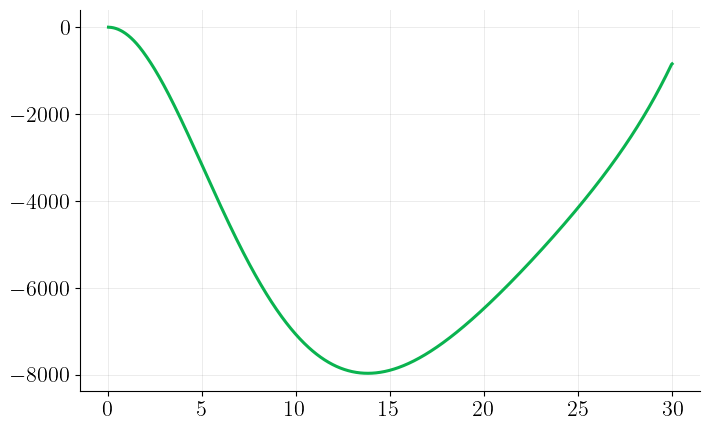

In [216]:
ηCHNC_unnormalized_mPaS_list = []
for plasma in η_plasma_list:
    ηCHNC_unnormalized_mPaS_list.append( get_ηBG(plasma)*AU_to_Pa*AU_to_s*1000  )

In [219]:
(Smith_lowT_η/ηCHNC_minT_mPas)

0.0253912044447515

In [223]:
TCHNC_eV_final = np.concatenate([[Smith_lowT_TeV] ,GP_Al_T_few[2:]])
ηCHNC_normalized_mPaS_list = np.array(ηCHNC_unnormalized_mPaS_list)* (Smith_lowT_η/ηCHNC_minT_mPas)

ηCHNC_mPas_unnormalized_final = np.concatenate([[ηCHNC_minT_mPas] , ηCHNC_unnormalized_mPaS_list ])
ηCHNC_mPas_normalized_final = np.concatenate([[Smith_lowT_η] , ηCHNC_normalized_mPaS_list ])

np.savetxt("/home/zach/plasma/hnc/TCCW/Final_TCCW/results/Al_η_MPas_Final.dat", np.array([TCHNC_eV_final, ηCHNC_mPas_unnormalized_final, ηCHNC_mPas_normalized_final ]).T, 
           header="T[eV]   η[mPas](unnormalized)  η[mPas](Smith-normalized) ", comments='')
# /home/zach/plasma/hnc/TCCW/Final_TCCW/results/η_cgs_Al_Final.dat